In [1]:
# required libraries
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
import numpy as np
from datetime import datetime, timedelta
import random
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score

In [2]:
# generate synthetic dataset usign numpy & random
random.seed(42)
np.random.seed(42)

users = ['Alice', 'Bob', 'Charlie', 'David', 'Eric']
days = pd.date_range(start="2024-07-01", periods=30).tolist()
data = []

for user in users:
    for day in days:
        # Determine shift type
        if user in ['Alice', 'Bob', 'Charlie']:  # Day shift
            start_hour = 9
            end_hour = 17
        else:  # Night shift
            start_hour = 22
            end_hour = 6  # spans next day

        # Generate active hours
        active_hours = []
        if start_hour < end_hour:
            active_hours = list(range(start_hour, end_hour))
        else:
            active_hours = list(range(start_hour, 24)) + list(range(0, end_hour))

        # Generate logs for each hour
        for hour in range(24):
            if hour in active_hours:
                # Normal activity
                if hour == active_hours[0]:  # first hour → high activity
                    count = np.random.randint(80, 120)
                elif hour == active_hours[-1]:  # last hour → low activity
                    count = np.random.randint(1, 20)
                else:
                    count = np.random.randint(20, 80)
            else:
                count = 0

                # Inject 10% off-shift activity randomly (simulate anomaly)
                if random.random() < 0.05:
                    count = np.random.randint(1, 10)

            # Save row
            data.append([
                user,
                day.date(),
                hour,
                count
            ])

df_logs = pd.DataFrame(data, columns=['UserName', 'Date', 'Hour', 'Count_of_logs'])

In [3]:
df_logs.shape

(3600, 4)

In [4]:
df_logs.to_csv("log_data.csv")

In [28]:
# convert categorical data
df_logs['UserName'] = df_logs['UserName'].map({'Alice':1, 'Bob':2, 'Charlie':3, 'David':4, 'Eric':5})

In [29]:
# find login & logout hours
active_logs = df_logs[df_logs['Count_of_logs'] > 0]

login_logout_df = active_logs.groupby(['UserName', 'Date']).agg(
    LoginHour=('Hour', 'min'),
    LogoutHour=('Hour', 'max')
).reset_index()
df_logs = df_logs.merge(login_logout_df, on=['UserName', 'Date'], how='left')

In [30]:
df_logs.sample(10)

,UserName,Date,Hour,Count_of_logs,LoginHour,LogoutHour
2966,5,2024-07-04,14,0,0,23
33,1,2024-07-02,9,115,3,16
2063,3,2024-07-26,23,0,9,21
223,1,2024-07-10,7,0,9,16
2627,4,2024-07-20,11,0,0,23
1936,3,2024-07-21,16,4,9,16
2213,4,2024-07-03,5,10,0,23
2304,4,2024-07-07,0,24,0,23
3312,5,2024-07-19,0,46,0,23
1244,2,2024-07-22,20,0,1,18


In [31]:
# scaling
df_login_events = df_logs[df_logs['Hour'] == df_logs['LoginHour']].copy()

X = df_login_events[['UserName', 'LoginHour']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [32]:
# implementing k-means 
# using no. of clusters=2 because it gives best accuracy 
# 2 clusters - one for day shift one for night shift

kmeans = KMeans(n_clusters=2, random_state=42)
predictions = kmeans.fit_predict(X_scaled)
df_login_events['Cluster'] = predictions
centroids = kmeans.cluster_centers_

In [33]:
# finding anomalous (off-hour) logins by flagging those data points 
# which are 10% of the most "distant" points

# calculate distance of each point from its cluster centroid
df_login_events['Distance'] = [
    np.linalg.norm(x - centroids[cluster])
    for x, cluster in zip(X_scaled, df_login_events['Cluster'])
]

# mark anomalies using 90th percentile threshold
threshold = np.percentile(df_login_events['Distance'], 90)
df_login_events['Anomaly'] = df_login_events['Distance'] > threshold

# show anomalies
anomalies = df_login_events[df_login_events['Anomaly'] == True][
    ['UserName', 'Date', 'Hour', 'LoginHour', 'Count_of_logs', 'Cluster']
]

print("Anomalous Logins Detected:\n")
print(anomalies.sort_values(['UserName', 'Date']))

Anomalous Logins Detected:

      UserName        Date  Hour  LoginHour  Count_of_logs  Cluster
1            1  2024-07-01     1          1              7        0
27           1  2024-07-02     3          3              5        0
99           1  2024-07-05     3          3              3        0
434          1  2024-07-19     2          2              7        0
552          1  2024-07-24     0          0              8        0
721          2  2024-07-01     1          1              3        0
792          2  2024-07-04     0          0              2        1
1225         2  2024-07-22     1          1              2        0
1275         2  2024-07-24     3          3              5        0
1296         2  2024-07-25     0          0              3        1
1322         2  2024-07-26     2          2              1        0
1491         3  2024-07-03     3          3              4        1
1707         3  2024-07-12     3          3              7        1
2067         3  2024

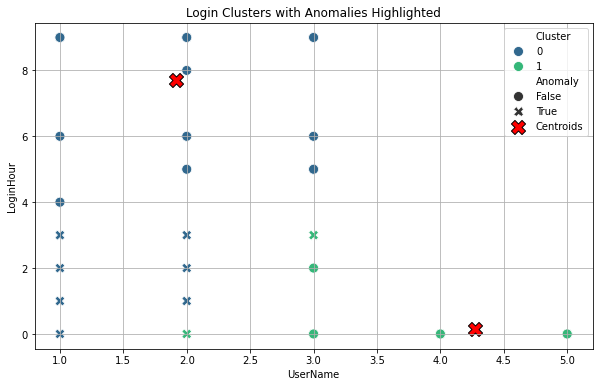

In [36]:
# visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_login_events,
    x='UserName',
    y='LoginHour',
    hue='Cluster',
    style='Anomaly',
    palette='viridis',
    s=100
)

# plot centroids
centroids_original = scaler.inverse_transform(centroids)
plt.scatter(
    centroids_original[:, 0],  # UserName axis
    centroids_original[:, 1],  # LoginHour axis
    s=200,
    c='red',
    label='Centroids',
    marker='X',
    edgecolor='black'
)

plt.title('Login Clusters with Anomalies Highlighted')
plt.xlabel('UserName')
plt.ylabel('LoginHour')
plt.grid(True)
plt.legend()
plt.show()


In [37]:
silhouette_score(X_scaled, predictions)

0.6687927364010054